# Homework 7: Decision Trees, Bagging, Random Forests
Part1 Decision Tree questions

Part2 Application to the real data

Part 3 Multiclass metrics

## Part 1 (3 pt) Basic elements of decision trees
**Write the code line that calculates the result.**

---



In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Q 1 (1 pt)** Given that 10 objects have reached a decision tree node, where 8 of them belong to class $C_1$, and 2 belong to class $C_2,$ calculate the impurity of this node, using entropy.

In [9]:
impurity = -0.8 * np.log(0.8) - 0.2 * np.log(0.2)
print(impurity)

0.5004024235381879


**Q2 (1 pt)** Additionally, it is known that the node from the previous task is not a leaf, and it is possible to split it in such a way that all objects of class $C_1$ end up in the left subtree and class $C_2$ objects end up in the right subtree. Calculate the (non-truncated) information gain criterion:

$$
Q = H(V) - \frac{|V_L|}{|V|}H(V_L) - \frac{|V_R|}{|V|}H(V_R).
$$
Now, $H(V)$ is calculated using Gini index:
$$
H(V) = \sum_{k=1}^C p_k(1-p_k),
$$
where $C$ is the number of classes (two in our case).

In [10]:
c1 = 8
c2 = 2
total = c1 + c2

gain = 2 * (c1/total) * (c2/total)
print(gain)

0.32000000000000006


**Q3 (1 pt)** During the tree construction using MAE metric for impurity (a regression problem is being solved), a leaf node is formed with 10 objects, and the values of the target variable for these objects are as follows: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]. What will be the model's predictions for these objects?

In [11]:
leaf_node = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]

prediction = sum(leaf_node)/len(leaf_node)
print(prediction)

40.6


## Part 2: (12 pt) Bagging and Random Forest
We well work with the dataset from HW6. Just run all the cells below to cteate data for training and evaluation.

---

In [12]:
#m=pd.read_csv(path+'Members.csv',index_col='MemberID')
m=pd.read_csv('https://media.githubusercontent.com/media/truongkhanhduy95/Heritage-Health-Prize/master/data/Members.csv',index_col='MemberID')
#m.head()

In [13]:
#claims=pd.read_csv(path+'Claims_Y1.csv',index_col='MemberID')
claims=pd.read_csv('https://media.githubusercontent.com/media/truongkhanhduy95/Heritage-Health-Prize/master/data/Claims.csv',index_col='MemberID')
#claims.head()

In [14]:
#days2=pd.read_csv(path+'DaysInHospital_Y2.csv',index_col='MemberID')
days2=pd.read_csv('https://media.githubusercontent.com/media/truongkhanhduy95/Heritage-Health-Prize/master/data/DaysInHospital_Y2.csv',index_col='MemberID')
#days2.head()

In [15]:
i = pd.notnull(m.AgeAtFirstClaim)
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: int(s.split('-')[0]) if s!='80+' else 80)

m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)

claims.CharlsonIndex = claims.CharlsonIndex.map({'0':0, '1-2':1, '3-4':3, '5+':5})
claims.LengthOfStay = claims.LengthOfStay.fillna(value=0)
claims.LengthOfStay = claims.LengthOfStay.map({0:0, '1 day':1, '2 days':2, '3 days':3, '4 days':4,\
    '5 days':5, '6 days':6, '1- 2 weeks':10, '2- 4 weeks':21, '4- 8 weeks':42, '26+ weeks':182})

In [16]:
f_Charlson = claims.groupby(['MemberID'])['CharlsonIndex'].max()
f_LengthOfStay = claims.groupby(['MemberID'])['LengthOfStay'].sum()

In [17]:
y = (days2['DaysInHospital']>0).astype('int').values
X = days2[['ClaimsTruncated']]
X = X.join(f_Charlson)
X = X.join(f_LengthOfStay)
X = X.join(m.AgeAtFirstClaim)

In [18]:
X = X.join(m.Sex)
X.head()

,ClaimsTruncated,CharlsonIndex,LengthOfStay,AgeAtFirstClaim,Sex
MemberID,,,,,
24027423,0,3,0,30,M
98324177,0,0,0,30,M
33899367,1,0,0,80,F
5481382,0,0,1,20,F
69908334,0,1,0,60,F


In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [22]:
transform = ColumnTransformer([('OneHot', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'), ['Sex'])], remainder='passthrough')

In [23]:
transform.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('OneHot',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='infrequent_if_exist'),
                                 ['Sex'])])

In [24]:
X_train_transformed = pd.DataFrame(transform.transform(X_train),columns=transform.get_feature_names_out())
X_train_transformed.head()

,OneHot__Sex_M,OneHot__Sex_nan,remainder__ClaimsTruncated,remainder__CharlsonIndex,remainder__LengthOfStay,remainder__AgeAtFirstClaim
0,1.0,0.0,0.0,1.0,0.0,50.0
1,0.0,0.0,0.0,0.0,0.0,20.0
2,0.0,0.0,0.0,0.0,0.0,70.0
3,0.0,1.0,0.0,0.0,0.0,50.0
4,1.0,0.0,0.0,1.0,0.0,70.0


In [25]:
X_test_transformed = pd.DataFrame(transform.transform(X_test),columns=transform.get_feature_names_out())
X_test_transformed.head()

,OneHot__Sex_M,OneHot__Sex_nan,remainder__ClaimsTruncated,remainder__CharlsonIndex,remainder__LengthOfStay,remainder__AgeAtFirstClaim
0,0.0,0.0,0.0,0.0,3.0,30.0
1,0.0,0.0,1.0,1.0,1.0,80.0
2,1.0,0.0,0.0,0.0,0.0,40.0
3,0.0,0.0,0.0,0.0,0.0,60.0
4,0.0,0.0,0.0,1.0,0.0,80.0


In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split

**Q4 (4 pt)** On the training set, find the optimal values for the hyperparameters `max_depth` and `min_samples_leaf` for the `DecisionTreeClassifier`. To do this:

(a) Create a dictionary with possible values to iterate over.

(b) Use grid search with cross-validation (we don't use validation set) using the F1-score as the criterion (parameter `scoring` in GridSearchCV).

(c) Choose the pair of values that provides the best quality.

Train the decision tree with the selected hyperparameters on the full training set. Evaluate the classification quality on the test set using Confusion Matrix and metrics recall, and auc_roc.

In [27]:
from sklearn.model_selection import GridSearchCV

In [28]:
dt = DecisionTreeClassifier()

In [29]:
params = {'criterion': ['gini', 'entropy'], 'max_depth': list(range(6)), 'min_samples_leaf': list(range(5))}

In [30]:
clf_dt = GridSearchCV(dt, params, scoring='f1')

In [31]:
clf_dt.fit(X_train_transformed, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
100 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _valid

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [0, 1, 2, 3, 4, 5],
                         'min_samples_leaf': [0, 1, 2, 3, 4]},
             scoring='f1')

In [32]:
clf_dt.best_params_

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1}

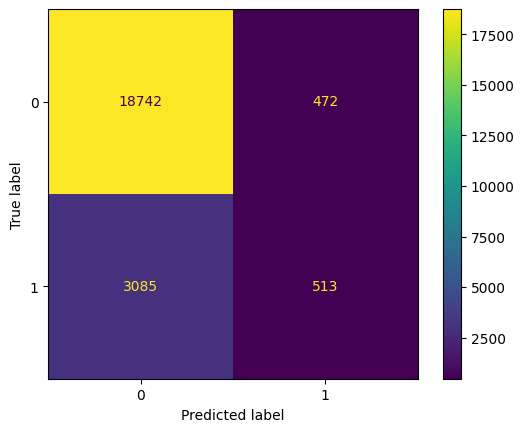

In [33]:
ConfusionMatrixDisplay.from_predictions(y_test, clf_dt.best_estimator_.predict(X_test_transformed))

In [34]:
recall_score(y_test, clf_dt.best_estimator_.predict(X_test_transformed))

0.14257921067259588

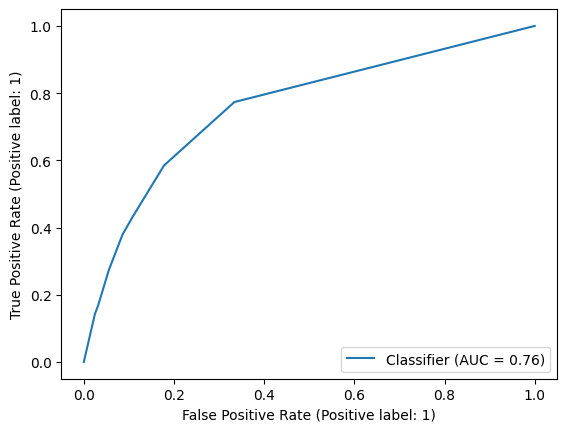

In [35]:
RocCurveDisplay.from_predictions(y_test, clf_dt.best_estimator_.predict_proba(X_test_transformed)[:,1])

**Q5 (3 pt)** Train [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) with 50 trees on the training set, use parameter `max_samples=0.9`. Estimate the quality using metrics from the previous question.

In [36]:
bc = BaggingClassifier(n_estimators=50, max_samples=0.9)

In [37]:
bc.fit(X_train_transformed, y_train)

BaggingClassifier(max_samples=0.9, n_estimators=50)

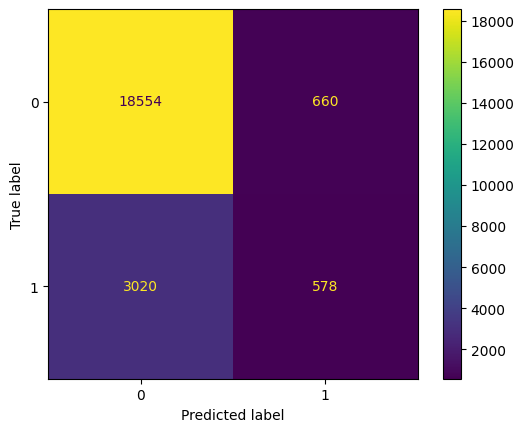

In [38]:
ConfusionMatrixDisplay.from_predictions(y_test, bc.predict(X_test_transformed))

In [39]:
recall_score(y_test, bc.predict(X_test_transformed))

0.16064480266814898

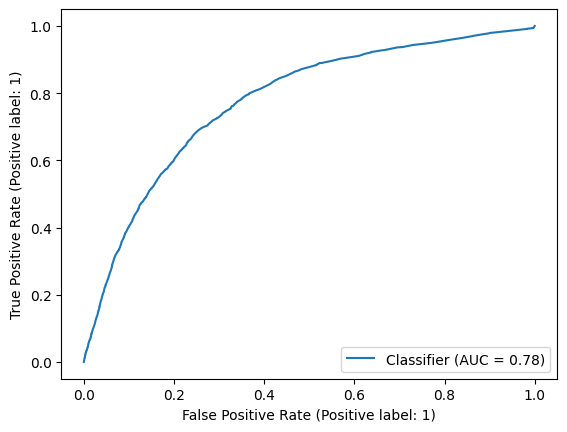

In [40]:
RocCurveDisplay.from_predictions(y_test, bc.predict_proba(X_test_transformed)[:,1])

**Q6 (4 pt)** On the training set, find the optimal values for the hyperparameters `max_depth` and `min_samples_split` for the `Random Forest`. To do this:

(a) Create a dictionary with possible values to iterate over.

(b) Use grid search with cross-validation (we don't use validation set) using the f1-score as the criterion (parameter `scoring="f1"` in GridSearchCV).

(c) Choose the pair of values that provides the best quality.

Train the random forest with the selected hyperparameters on the full training set. Evaluate the classification quality on the test set using Confusion Matrix and metrics recall, and auc_roc.

Which of these models worked better?
***The Decision Tree Classifier model seemed to work the best***

In [41]:
clf_rf = RandomForestClassifier(class_weight='balanced')

In [42]:
clf_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [43]:
params = {'criterion': ['gini', 'entropy'], 'max_depth': list(range(6)), 'min_samples_split': list(range(8))}

In [44]:
clf = GridSearchCV(clf_rf, params, scoring='f1')

In [45]:
clf.fit(X_train_transformed, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
180 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [0, 1, 2, 3, 4, 5],
                         'min_samples_split': [0, 1, 2, 3, 4, 5, 6, 7]},
             scoring='f1')

In [46]:
clf.best_params_

{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5}

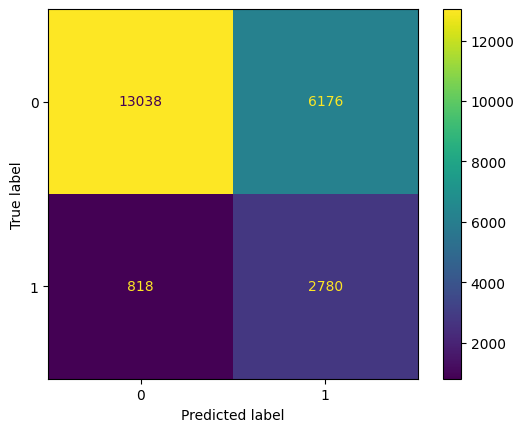

In [47]:
ConfusionMatrixDisplay.from_predictions(y_test, clf.best_estimator_.predict(X_test_transformed))

In [48]:
recall_score(y_test, clf.best_estimator_.predict(X_test_transformed))

0.7726514730405781

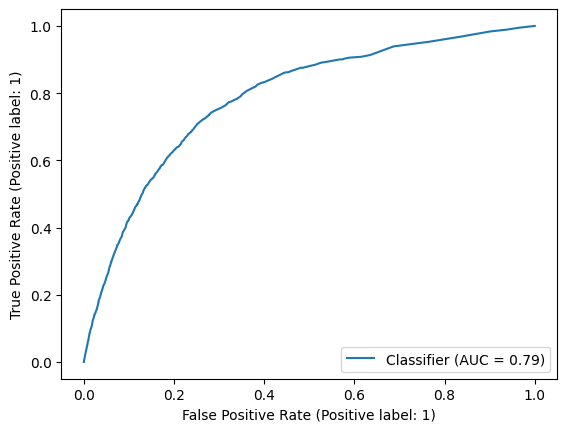

In [49]:
RocCurveDisplay.from_predictions(y_test, clf.best_estimator_.predict_proba(X_test_transformed)[:,1])

**Q7 (1 pt)** For the best model report the most relevant features, parameter `feature_importances_`

In [50]:
pd.DataFrame(clf.best_estimator_.feature_importances_, X_train_transformed.columns).sort_values(0, ascending=False)

,0
remainder__LengthOfStay,0.635017
remainder__AgeAtFirstClaim,0.097922
OneHot__Sex_nan,0.090750
remainder__CharlsonIndex,0.085125
remainder__ClaimsTruncated,0.083533
OneHot__Sex_M,0.007653


## Part 3.
**Q8 (5 pt)** Given the confusion matrix, write the expression that calculates macro- and micro- f1-score. For macro-averaging we calculate f1 for every class and then average. For micro-averaging we average TP, FP, FN and then calculate metrics.

**Write the code that calculates f1-score using the numbers below**

In [51]:
np.random.seed(42)
y_target = np.random.randint(0, 3, 20)
y_pred = np.random.randint(0, 3, 20)

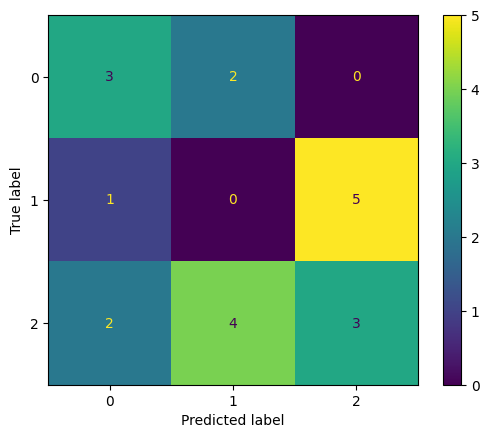

In [52]:
ConfusionMatrixDisplay.from_predictions(y_target, y_pred)

In [53]:
def calculate_f1_score(tp, fp, fn):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    if precision + recall == 0:
        return 0

    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score



f1_averaged = 0

for positive_label in range(3):
  tp = 0
  fp = 0
  fn = 0
  for i in range(len(y_target)):
    if y_target[i] == positive_label and y_pred[i] == positive_label:
        tp += 1
    elif y_target[i] != positive_label and y_pred[i] == positive_label:
        fp += 1
    elif y_target[i] == positive_label and y_pred[i] != positive_label:
        fn += 1

  f1_averaged += calculate_f1_score(tp, fp, fn)

f1_averaged /= 3

In [54]:
f1_macro = f1_averaged

In [55]:
from sklearn.metrics import make_scorer, f1_score

In [56]:
assert np.abs(f1_macro-f1_score(y_target, y_pred, average="macro")) < 1e-5

In [57]:
tp = 0
fp = 0
fn = 0

for positive_label in range(3):
  for i in range(len(y_target)):
    if y_target[i] == positive_label and y_pred[i] == positive_label:
        tp += 1
    elif y_target[i] != positive_label and y_pred[i] == positive_label:
        fp += 1
    elif y_target[i] == positive_label and y_pred[i] != positive_label:
        fn += 1

tp /= 3
fp /= 3
fn /= 3

f1_micro_calculated = calculate_f1_score(tp, fp, fn)

In [58]:
f1_micro = f1_micro_calculated

In [59]:
assert np.abs(f1_micro-f1_score(y_target, y_pred, average="micro")) < 1e-5